[View in Colaboratory](https://colab.research.google.com/github/kabrol98/PASSNYC-Data-Challenge/blob/master/kaggle_challenge_05.ipynb)

# Data

I'm going to import all libraries and upload all necessary files here.

I will be uploading into colab. Setting up a virtual environment for myself is not an andeavor I'm interested in wasting this weekend on.

In [4]:
import pandas as pd
import sys
import tensorflow as tf
import numpy as np
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *
from keras.models import load_model
import io
from google.colab import files
import math
import copy
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:

uploaded = files.upload()

school_data = pd.read_csv(io.StringIO(uploaded['2016 School Explorer.csv'].decode('utf-8')))
# turnout_data = pd.read_csv(io.StringIO(uploaded['D5 SHSAT Registrations and Testers.csv'].decode('utf-8')))
nytdf = pd.read_csv(io.StringIO(uploaded['nytdf.csv'].decode('utf-8')))
middleschoolDirectory = pd.read_csv(io.StringIO(uploaded["2018_DOE_Middle_School_Directory.csv"].decode('utf-8')))
middleschoolAttendance = pd.read_csv(io.StringIO(uploaded["2016-2017_Monthly_Attendance.csv"].decode('utf-8')))


Saving 2016 School Explorer.csv to 2016 School Explorer.csv
Saving 2016-2017_Monthly_Attendance.csv to 2016-2017_Monthly_Attendance.csv
Saving 2018_DOE_Middle_School_Directory.csv to 2018_DOE_Middle_School_Directory.csv
Saving D5 SHSAT Registrations and Testers.csv to D5 SHSAT Registrations and Testers.csv
Saving nytdf.csv to nytdf.csv


In [6]:

middleschoolAttendance.head()

year_8_attendance = middleschoolAttendance.query('GradeLevel == \'08\'')

year_8_attendance.head()

,School,MonthCode,CalMonth,GradeLevel,GradeSort,RosterCount,Absent,Present,Released
217,01M034,5,Jan,08,8,62,131,1086,0
227,01M034,6,Feb,08,8,60,80,760,0
237,01M034,7,Mar,08,8,60,126,1175,0
247,01M034,8,Apr,08,8,60,80,697,0
257,01M034,9,May,08,8,60,95,1225,0


In [7]:
# Join all relevant dataframs
schoolExplorer = school_data
middleschoolDirectory = middleschoolDirectory.set_index('schooldbn')

schoolExplorer = schoolExplorer.set_index('Location Code')
nytdf = nytdf.set_index('DBN')

explorer_nyt = schoolExplorer.join(nytdf)
nytCombined = nytdf.join(schoolExplorer)

nytCombined.head()

,DataName,SchoolName1,SchoolName2,NumSHSATTestTakers,NumSpecializedOffers,OffersPerStudent,PctBlackOrHispanic,Adjusted Grade,New?,Other Location Code in LCGMS,...,Grade 8 Math - All Students Tested,Grade 8 Math 4s - All Students,Grade 8 Math 4s - American Indian or Alaska Native,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged
DBN,,,,,,,,,,,,,,,,,,,,,
20K187,THE CHRISTA MCAULIFFE SCHOOL\I.S. 187,Intermediate School 187,The Christa McAuliffe School,251,205,75%,8%,NaN,NaN,NaN,...,339.0,312.0,0.0,0.0,0.0,246.0,59.0,0.0,0.0,196.0
21K239,MARK TWAIN I.S. 239 FOR THE GIFTED & TALENTED,Intermediate School 239,The Mark Twain Intermediate School for the Gif...,336,196,46%,13%,NaN,NaN,NaN,...,366.0,209.0,0.0,5.0,4.0,98.0,99.0,3.0,0.0,65.0
03M054,J.H.S. 054 BOOKER T. WASHINGTON,Junior High School 54,The Booker T. Washington School,257,150,53%,23%,NaN,NaN,NaN,...,34.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15K051,M.S. 51 WILLIAM ALEXANDER,Midde School 51,The William Alexander School,280,122,33%,28%,NaN,NaN,NaN,...,160.0,37.0,0.0,5.0,5.0,0.0,22.0,0.0,0.0,8.0
02M312,NEW YORK CITY LAB MIDDLE SCHOOL FOR COLLABORAT...,NaN,New York City Lab Middle School for Collaborat...,163,113,62%,8%,NaN,NaN,NaN,...,42.0,7.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0


# Feature Engineering

Picking, amending, and converting the necessary features into usable values for a predictive model.

In [8]:
#Pick features
features = ['Percent of Students Chronically Absent','Average Math Proficiency','Economic Need Index','Average ELA Proficiency', 'Latitude', 'Longitude', 'NumSHSATTestTakers', 'Student Attendance Rate']
target = 'NumSHSATTestTakers'

nytCombinedFiltered = nytCombined.query('NumSHSATTestTakers != 0')

nytCombinedFiltered[features].describe()

,Average Math Proficiency,Economic Need Index,Average ELA Proficiency,Latitude,Longitude,NumSHSATTestTakers
count,530.000000,531.000000,530.000000,536.000000,536.000000,537.000000
mean,2.668849,0.657750,2.574906,40.738840,-73.915875,47.204842
std,0.486156,0.191868,0.375443,0.086535,0.075129,61.158551
min,1.890000,0.059000,1.910000,40.507803,-74.243221,6.000000
25%,2.270000,0.545500,2.280000,40.671637,-73.955888,15.000000
50%,2.610000,0.710000,2.490000,40.728875,-73.919367,26.000000
75%,2.980000,0.806500,2.790000,40.820391,-73.880919,46.000000
max,4.190000,0.938000,3.930000,40.899321,-73.713022,394.000000


## Helper functions
Set of functions to normalize data and remove percentages.

In [0]:
# convert string valued percentages into floats within [0,1]
def removePercent(df,columnNames):
  for i in range(len(columnNames)):
    col_string = df[columnNames[i]].str
    df[columnNames[i]] = col_string.rstrip('%').astype('float') / 100.0
    pass
  return df
  
# for values in arbitrary ranges, normalize across [-1,1]
def normalize_series(df, labels):
  for label in labels:
#     for sigma = 1 standard deviation, ~97% of datapoints should be within [-3sigma,sigma]
    df[label] = (df[label] - df[label].mean()) / (3 * df[label].std())
    pass
  return df


In [10]:
# Applying helpers to dataset

nytApplyFilters = removePercent(nytCombinedFiltered.copy(), ['Student Attendance Rate', 'Percent of Students Chronically Absent'])

nytApplyFilters = normalize_series(nytApplyFilters, ['Average Math Proficiency', 'Average ELA Proficiency', 'Latitude', 'Longitude'])

nytApplyFilters = nytApplyFilters.dropna(subset=[target])
nytApplyFilters.fillna(0,inplace = True)

nytApplyFilters[features].describe()


,Percent of Students Chronically Absent,Average Math Proficiency,Economic Need Index,Average ELA Proficiency,Latitude,Longitude,NumSHSATTestTakers,Student Attendance Rate
count,537.000000,5.370000e+02,537.000000,5.370000e+02,5.370000e+02,5.370000e+02,537.000000,537.000000
mean,0.196108,7.939025e-17,0.650400,-2.514025e-16,1.860378e-14,-5.659532e-14,47.204842,0.913762
std,0.150459,3.311496e-01,0.202953,3.311496e-01,3.330222e-01,3.330222e-01,61.158551,0.151724
min,0.000000,-5.340184e-01,0.000000,-5.903301e-01,-8.899587e-01,-1.452364e+00,6.000000,0.000000
25%,0.100000,-2.666146e-01,0.538000,-2.618291e-01,-2.579054e-01,-1.773479e-01,15.000000,0.920000
50%,0.170000,-3.349339e-02,0.708000,-7.538267e-02,-3.731623e-02,-1.418521e-02,26.000000,0.940000
75%,0.270000,2.133409e-01,0.806000,1.820910e-01,3.133669e-01,1.541464e-01,46.000000,0.960000
max,1.000000,1.042978e+00,0.938000,1.203107e+00,6.181726e-01,9.000141e-01,394.000000,1.000000


In [0]:
# Setting up features as a vector
# Separating training and testing for k-fold vallidation
num_folds = 10
N = nytApplyFilters.shape[0]

test_set = nytApplyFilters[0: N / num_folds]
train_set = nytApplyFilters[N / num_folds : N]

test_set = test_set.filter(features)
train_set = train_set.filter(features)

In [12]:
# X and Y from train sets

X = train_set.drop(target, axis=1).values

# Using the output as a percentage

Y = train_set[[target]].values

print(X.shape)
print(Y.shape)

(484, 7)
(484, 1)


# Training Neural Network


In [11]:
numFeatures = len(features)
# Define the model
model = Sequential()
activationFuntion = 'relu'
model.add(Dense(20, input_dim=numFeatures-1, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
# model.compile(loss="mean_squared_error", optimizer="adam")

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])


#Train
model.fit(
    X,
    Y,
    epochs=200,
    shuffle=True,
    verbose=0
)


X_test = test_set.drop(target, axis=1).values
Y_test = test_set[[target]].values

test_error_rate = model.evaluate(X_test, Y_test, verbose=0)

testErrorArray.append(test_error_rate)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))
print("Here: \n%s: %.8f%%" % (model.metrics_names[2], test_error_rate[2]))

The mean squared error (MSE) for the test data set is: [28634.947302476416, 142.72677036501327, 0.0]
Here: 
acc: 0.00000000%


Best "acc" achieved by this prediction network: 0.01887%.
Best MSE on real valued Num of SHSAT Test Takers: 142.65

# Radial Basis Function (RBF) Model

I'm going to try a Radial Basis Function Model to minimize in-sample Mean Squared Error.

Value to beat: 142.65.

## Intuition

You may not feel the connection immediately, even by looking at the math, but I think of radial basis functions as probability distributions around certain points.

This is the function I've chosen; I've chosen it because the brilliant Dr. Abu Mustafa of the online Caltech ML course on YouTube picked it out when explaining the math behind this. My whole model is based around it:

\begin{equation}
\Large
f(\mathbf{x}) = \sum_{k=1}^K w_ke^{-\lambda \| \mathbf{x} - \mathbf{\mu_k} \| ^ 2}
\end{equation}


What does this mean? Well, basically, it follows directly from the idea of continuity. What if our target function predicting $y$ was continuous? If that were true, then for a point at a certain location, we could assume that points close to that location would be kind of close to the value at that location. It's becomes a cumulative probability distribution, where every point in the training set is understood to have an area of influence that tapers off based on how far away an input is from that point. It also has a weight, or the value that area of influence imposes on the input.

So the influence on any input $ x $ is dependent on the exponential distribution to a given point $ \mu $ by the following equation:


\begin{equation}
\large
\forall \mu, f(\mathbf{x}) \propto e^{-\lambda \mathbf{ \| x - \mu \| } ^ 2}
\end{equation}




Now in this case $ \lambda$ is the rate at which the influence of any given point tapers off as the input moves farther away for a $\mu$. Changing the value of lambda decides how far close to each $\mu$ an input has to be to get the influence.
and by that logic, we can conclude that if we have $K$ $\mu$'s,


\begin{equation}
\large
f(\mathbf{x}) = \sum_{k=1}^K w_ke^{-\lambda \| \mathbf{x} - \mathbf{\mu_k} \| ^ 2}
\end{equation}

Notice how I've been really deliberate in calling each point $\mu$. If you know some statistics you picked up on the fact that its a symbol that denotes a mean. The reason for this is simply to improve on computation. Some datasets have records on the order of $10^5$. That's ridiculous, and it would make no sense to to run the whole calculation. So instead we generate a set of $K$ different $\mu$s, or 'K-means'. These means are representative points for the entire dataset given to us. I haven't come across any specific rule of thumb while choosing $K$, so what I'm going to do is have $K \propto \log{N}$. After all, the whole point of having $K$ is to reduce the number of computations you have to go through.

## Process



### Step 1:
K-means clustering on feature sets.

### Step 2:
Define the RBF equation as follows.

\begin{equation}
\large
y = \sum_{k=1}^K w_ke^{-\lambda \| \mathbf{x} - \mathbf{\mu_k} \| ^ 2}
\end{equation}

with precision rate $\lambda$ where $\mu_k$ is a mean point for all $K$- means.

### Step 3:
Build model to find least square values for all weights $w_k$.

### Step 4:
Test model with different precision rates, try to minimize cost.

## Step 1: K means clustering

### Lloyd's algorithm
I'm going to implement K-means clustering using Lloyd's algorithm on the feature vector $ \mathbf{x} $,
using the following iterative implementation for Lloyd's algotihm.

\begin{equation} \mathbf{\mu_0} = random \in {\mathbf{x}} \end{equation}

\begin{equation} \mathbf{S_0} =  \{ \mathbf{x} : \forall \mu, \| \mathbf{x} - \mathbf{\mu_0} \| \leq \| \mathbf{x} - \mathbf{\mu} \|\} \end{equation}

\begin{equation} \mathbf{\mu_{n+1}} = \frac{1}{\mathbf{\|S_n\|}} \sum_{\mathbf{x} \in \mathbf{S_n}} \mathbf{x} \end{equation}

\begin{equation} \mathbf{S_{n+1}} =  \{ \mathbf{x} : \forall \mu, \| \mathbf{x} - \mathbf{\mu_{n+1}} \| \leq \| \mathbf{x} - \mathbf{\mu} \|\} \end{equation}


In [0]:
#  Lloyd's algorithm: Implmentation.
# Assume feature engineering has been done.
class LloydMeans:
  
  def __init__ (self, k, df, labels):
    self.pointMatrix = df[labels].as_matrix()
    self.df = df
    self.labels = labels
    self.k = k
    pass
  
  def assign_means(self, num_trials, num_iterations):
    best_error = float("inf") # Best error is positive infinity
    best_mu = []
    best_meanSet = []
    clustered_features = self.labels
    pointMatrix = self.pointMatrix
    k = self.k
    df = self.df

    for trial in range(num_trials):
      mu = self.init_mu(df, clustered_features, k)

      for i in range(num_iterations):
        #iteratively update the clusters and cluster means nunm_iterations times
        meanSet = self.update_clusters(pointMatrix, mu, k)
        mu = self.update_cluster_points(meanSet, mu, k)
        pass

      #calculate error of current mu model
      model_error = self.calculate_total_error(meanSet, mu)

      print("MSE for trial {} : {}".format(trial, model_error))

      #always take the best model w/ minimum error
      if(model_error < best_error):
        best_error = model_error
        best_mu = mu
        best_meanSet = meanSet
        pass
      pass
    print("Best error is {}".format(best_error))
#     df = assign_final_clusters(pointMatrix, best_mu, k, self.df)
    return best_mu
  
  def normalize_matrix(self, df, labels):
    mat = df[labels].as_matrix()
    # transform all datapoints so ~97% of values are in [-1, 1]
    for i in range(mat.shape[0]):
      for j in range(mat.shape[1]):
        mat[i][j] = (mat[i][j] - df[labels[j]].mean()) / (3 * df[labels[j]].std())
        pass
      pass
    return mat

  def init_mu(self, df, labels, k):
      mu = np.zeros((k, len(labels)))
      for i in range(len(labels)):
        for j in range(k):
#           initialize random float in [-1, 1]
          offset = np.random.ranf() * 6 - 3
          mu[j][i] = df[labels[i]].mean() + offset
      return mu

  def update_clusters(self, pointMatrix, mu, k):
    meanSet = [[] for i in range(k)]
  #   iterate over points
    for i in range(pointMatrix.shape[0]):
      minIndex = 0
      minDistance = np.linalg.norm(pointMatrix[i] - mu[minIndex])
  #     iterate over mu (mean points)
      for j in range(k):
        dist = np.linalg.norm(pointMatrix[i] - mu[j])
  #       pick j with the minimum distance from i
        if(dist < minDistance):
          minDistance = dist
          minIndex = j
          pass
        pass
    #   Add point i to mu[j]'s cluster'
      meanSet[minIndex].append(pointMatrix[i])
      pass
    return meanSet

  def assign_final_clusters(self, pointMatrix, mu, k, df):
  #   iterate over points (repeating update_clusters)
    for i in range(pointMatrix.shape[0]):
      minIndex = 0
      minDistance = np.linalg.norm(pointMatrix[i] - mu[minIndex])
  #     iterate over mu (mean points)
      for j in range(k):
        dist = np.linalg.norm(pointMatrix[i] - mu[j])
  #       pick j with the minimum distance from i
        if(dist < minDistance):
          minDistance = dist
          minIndex = j
          pass
        pass
    #   Assign final cluster values to dataframe
      df.loc[df.index[i], 'cluster'] = minIndex
      pass
    return df

  def update_cluster_points(self, meanSet, mu, k):
  #   iterate over mu
    for i in range(k):
      set_sum = np.zeros(mu[i].shape)
  #     iterate over mu[i]'s cluster'
      for j in range(len(meanSet[i])):
        # sum up all the positions of each point
        set_sum += meanSet[i][j]
        pass
      # update mu to the average of each point in mu's cluster
      if len(meanSet[i]) != 0:
        mu[i] = set_sum / len(meanSet[i])
        pass
      pass
    return mu

  def calculate_total_error(self, meanSet, mu):
    mserror = 0
    N = 0
    for i in range(self.k):
      for j in range(len(meanSet[i])):
        error = np.linalg.norm(meanSet[i][j] - mu[i])
        mserror += error * error
        N += 1
        pass
      pass
    return mserror / N
  
  pass



In [78]:
# Lloyd's Algorithm- application

# Set up X as independent dataframe with features vector
clusterDF = train_set
featureLabels = copy.deepcopy(features)
featureLabels.remove(target)

# Let K increase logarithmically with N.
# This will help optimize clustering and create good representatives.

train_N = clusterDF.shape[0]
K = 5 * int(math.floor(math.log(train_N)))

lloyd = LloydMeans(K, clusterDF, featureLabels)
mu = lloyd.assign_means(num_iterations = 30, num_trials = 10)

MSE for trial 0 : 0.129738119818
MSE for trial 1 : 0.247218580904
MSE for trial 2 : 0.278175703223
MSE for trial 3 : 0.298511482234
MSE for trial 4 : 0.195443270384
MSE for trial 5 : 0.178731272948
MSE for trial 6 : 0.175493791762
MSE for trial 7 : 0.174968488729
MSE for trial 8 : 0.266410064383
MSE for trial 9 : 0.167184996173
Best error is 0.129738119818


## Step 2: Defining the Radial Basis Function

Here is the function again, just to remind myself, and because LaTEX is awesome.

\begin{equation}
\large
f(\mathbf{x}) = \sum_{k=1}^K w_ke^{-\lambda \| \mathbf{x} - \mathbf{\mu_k} \| ^ 2}
\end{equation}

**Note: $\lambda$ in the code is "precision_rate". This is because the phrase "lambda" reads as the start of a lambda function, so I can't use it to name a variable.**

In [0]:
def _predict (mu, w, x, precision_rate):
#   Sum over mu
  sum = 0
  for i in range(mu.shape[0]):
#     distance between point x and mu
    dist = np.linalg.norm(x - mu[i])
#   square distance, multiply by lambda
    exponent = (- precision_rate) * dist * dist
#   multiply exponent by weight, add to total
    sum += (w[i] * math.exp(exponent))
    pass
  return sum


This is a good start, but we have to visualize this as a matrix instead of a function before we can solve for $ \mathbf{w} $

We're going to do this by creating the following matrix:

\begin{equation} \mathbf{A_{1,K}} = 
\begin{pmatrix} 
e^{-\lambda \| \mathbf{x} - \mathbf{\mu_1} \| ^ 2} & \cdots & e^{-\lambda \| \mathbf{x} - \mathbf{\mu_K} \| ^ 2}
\end{pmatrix} \end{equation}

This way, the new equation is:

\begin{equation}
\begin{bmatrix} 
e^{-\lambda \| \mathbf{x} - \mathbf{\mu_1} \| ^ 2} & \cdots & e^{-\lambda \| \mathbf{x} - \mathbf{\mu_K} \| ^ 2}
\end{bmatrix}
\begin{bmatrix}
w_1 \\ \vdots \\ w_K
\end{bmatrix} = y
\end{equation}


or

\begin{equation} \mathbf{Aw} = y \end{equation}

In [0]:
def predict (mu, w, x, precision_rate):
  A = np.zeros((1, mu.shape[0]))
  for i in range(mu.shape[0]):
#   distance between point x and mu
    dist = np.linalg.norm(x - mu[i])
#   square distance, multiply by lambda
    exponent = (- precision_rate) * dist * dist
    A[0][i] = math.exp(exponent)
    pass
  return np.dot(A, w)

## Step 3: Training.


This is going to be the most fun part.
Extend our previous matrix $ \mathbf{A} $ to all N points in our dataset, creating a K by N matrix.

\begin{equation}
\mathbf{A_{N,K}} = 
\begin{bmatrix} 
e^{-\lambda \| \mathbf{x_1} - \mathbf{\mu_1} \| ^ 2} & 
e^{-\lambda \| \mathbf{x_1} - \mathbf{\mu_2} \| ^ 2} & \cdots & 
e^{-\lambda \| \mathbf{x_1} - \mathbf{\mu_K} \| ^ 2} 
\\
e^{-\lambda \| \mathbf{x_2} - \mathbf{\mu_1} \| ^ 2} & 
e^{-\lambda \| \mathbf{x_2} - \mathbf{\mu_2} \| ^ 2} & \cdots &
e^{-\lambda \| \mathbf{x_2} - \mathbf{\mu_K} \| ^ 2}
\\
\vdots & \vdots & \ddots & \vdots
\\
e^{-\lambda \| \mathbf{x_N} - \mathbf{\mu_1} \| ^ 2} &
e^{-\lambda \| \mathbf{x_N} - \mathbf{\mu_2} \| ^ 2} &\cdots &
e^{-\lambda \| \mathbf{x_N} - \mathbf{\mu_K} \| ^ 2} 
\end{bmatrix}
\end{equation}

Now,

\begin{equation} \begin{bmatrix} 
e^{-\lambda \| \mathbf{x_1} - \mathbf{\mu_1} \| ^ 2} & 
e^{-\lambda \| \mathbf{x_1} - \mathbf{\mu_2} \| ^ 2} & \cdots & 
e^{-\lambda \| \mathbf{x_1} - \mathbf{\mu_K} \| ^ 2} 
\\
e^{-\lambda \| \mathbf{x_2} - \mathbf{\mu_1} \| ^ 2} & 
e^{-\lambda \| \mathbf{x_2} - \mathbf{\mu_2} \| ^ 2} & \cdots &
e^{-\lambda \| \mathbf{x_2} - \mathbf{\mu_K} \| ^ 2}
\\
\vdots & \vdots & \ddots & \vdots
\\
e^{-\lambda \| \mathbf{x_N} - \mathbf{\mu_1} \| ^ 2} &
e^{-\lambda \| \mathbf{x_N} - \mathbf{\mu_2} \| ^ 2} &\cdots &
e^{-\lambda \| \mathbf{x_N} - \mathbf{\mu_K} \| ^ 2} 
\end{bmatrix} \begin{bmatrix}
w_1 \\ w_2 \\ \vdots \\ w_K
\end{bmatrix} = \begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_N
\end{bmatrix} \end{equation}

or,

\begin{equation} \mathbf{Aw = y} \end{equation}

So, to solve for $ \mathbf{w} $ given a reasonable lambda we use the old Math 415 least squares regression equation

\begin{equation}
\mathbf{w = (A^TA)^{-1}A^Ty}
\end{equation}


We're also going to write a loss function to look for a good MSE

In [0]:
def train (X, Y, precision_rate, mu):
  A = np.zeros((X.shape[0], mu.shape[0]))
#   iterate over X
  for i in range(X.shape[0]):
#     iterate over mu
    for j in range(mu.shape[0]):
#     create vectors for x and mu
      _x = np.transpose([X[i]])
      _mu = np.transpose([mu[j]])
#     Take the distance between point x and mu
      dist = np.linalg.norm(_x - _mu)
  #   square distance, multiply by lambda
      exponent = (- precision_rate) * dist * dist
      A[i][j] = math.exp(exponent)
      pass
    pass
  
#   Get ATA
  transpose = np.transpose(A)
  ATA = np.dot(transpose, A)
  
#   Invert ATA
  pseudoInv = np.linalg.inv(ATA)
  
#   Take(ATA)^-1 ATy
  res = np.dot(transpose, Y)
  res = np.dot(pseudoInv, res)
  return res
  
  
def get_loss(X, Y, precision_rate, mu, w):
  mse = 0
  count = 0
  for i in range(X.shape[0]):
    predicted = predict(mu, w, X[i], precision_rate)
    err = Y[i] - predicted
    mse += err * err
    count += 1
    pass
  res = mse / count
  return res

## Step 4: Application

I've now written more latex than code and tested none of the code. Let's see if anything happens.
I'm going to put everything in a for loop that tries different lambdas.

In [91]:
step = 0.000005
precision_rate = 0.0005
X = train_set.drop(target, axis=1).values
Y = train_set[[target]].values

test_X = test_set.drop(target, axis=1).values
test_Y = test_set[[target]].values

best_precision = precision_rate
best_error = float('inf')

for i in range(20):
#   Train for given precision rate
  w = train(X, Y, precision_rate, mu)
#   Get the error
  current_error = get_loss(test_X, test_Y, precision_rate, mu, w)
  print('MSE for lambda {} was {}'.format(precision_rate, current_error))
  
#   Replace the best error and rate if a better set is found
  if current_error < best_error:
    best_error = current_error
    best_precision = precision_rate
    pass
  precision_rate += step
  pass

print('Best MSE was {} with precision rate {}'.format(best_error, best_precision))
  

MSE for lambda 0.0005 was [[21813.18868148]]
MSE for lambda 0.000505 was [[29815.91504766]]
MSE for lambda 0.00051 was [[33550.49807164]]
MSE for lambda 0.000515 was [[68577.65349522]]
MSE for lambda 0.00052 was [[30218.1315357]]
MSE for lambda 0.000525 was [[37512.12033987]]
MSE for lambda 0.00053 was [[14239.39156975]]
MSE for lambda 0.000535 was [[34363.78831057]]
MSE for lambda 0.00054 was [[28831.84147649]]
MSE for lambda 0.000545 was [[24670.82533999]]
MSE for lambda 0.00055 was [[20519.23974181]]
MSE for lambda 0.000555 was [[11413.12614696]]
MSE for lambda 0.00056 was [[65123.83192398]]
MSE for lambda 0.000565 was [[27451.04504692]]
MSE for lambda 0.00057 was [[30581.46086842]]
MSE for lambda 0.000575 was [[143328.08564603]]
MSE for lambda 0.00058 was [[25851.86104825]]
MSE for lambda 0.000585 was [[299360.53023674]]
MSE for lambda 0.00059 was [[27242.45876025]]
MSE for lambda 0.000595 was [[27628.24873]]
Best MSE was [[11413.12614696]] with precision rate 0.000555


## Review:



#### ...Fuck.



```
MSE for lambda 0.00055 was [[133638.7555843]]
MSE for lambda 0.00054 was [[28831.84147649]]
MSE for lambda 0.000545 was [[24670.82533999]]
MSE for lambda 0.00055 was [[20519.23974181]]
MSE for lambda 0.000555 was [[11413.12614696]]
MSE for lambda 0.00056 was [[65123.83192398]]
MSE for lambda 0.000565 was [[27451.04504692]]
MSE for lambda 0.00057 was [[30581.46086842]]
MSE for lambda 0.000575 was [[143328.08564603]]
MSE for lambda 0.00058 was [[25851.86104825]]
MSE for lambda 0.000585 was [[299360.53023674]]
MSE for lambda 0.00059 was [[27242.45876025]]
MSE for lambda 0.000595 was [[27628.24873]]
Best MSE was [[11413.12614696]] with precision rate 0.000555
```


#### Possible issues:
 - N too small.
 - K too small.
 - Features are too few.
 - lambda uniform across means.
 - model not complex enough.
 - Some stupid mistake somewhere scales values wrong. You know, by a factor of $10^5$.
 
#### Possible Solutions:
  - Fuck this dataset. This dataset is horrible. 400 points, 7 features.
  - Try to find/ implement variable lambda, and use iterative algorithm to regress w and lambda
  - Implement RBF Network with multiple layers. This would be ridiculous in terms of debugging and time commitment.

#Refining the RBF: Multiple $ \lambda$s

The thing about the radial basis function is that it works on distributions with two values, not one. Some points should have stronger influence areas than others. But our model applies a single $ \lambda$ to all means.

Now I'm going to try to beat the ridiculous MSE from the single $\lambda$ model of 15223.95151741 by using multiple $\lambda$s, so the new function will be as follows:

\begin{equation}
\large
f(\mathbf{x}) = \sum_{k=1}^K w_ke^{-\lambda_k \| \mathbf{x} - \mathbf{\mu_k} \| ^ 2}
\end{equation}

Here's the thing: this is a LOT more complicated than it looks.
When we were optimizing for the linear weight vector $\mathbf{w}$, we were able to pull off a basic linear algebra trick, but $\lambda$ affects the equiation nonlinearly. That means the only way to train this model for $\lambda$ is through stochastic gradient descent, which can be done, but it is in no way ideal in this situation and is going to depend entirely on how accurate my math is.

## 1: Redefining prediction function

I'm going to call this new function forward, because the process by which I train will also act on a single x, and I'm going to call it backward. The reason is that this model is going to update itself every time it gets a new variable.

In [0]:
def forward (mu, w, x, precision_rate):
  A = np.zeros((1, mu.shape[0]))
  for i in range(mu.shape[0]):
#   distance between point x and mu
    dist = np.linalg.norm(x - mu[i])
#   square distance, multiply by lambda
    exponent = (- precision_rate[i]) * dist * dist
    A[0][i] = math.exp(exponent)
    pass
  return np.dot(A, w)
  

## 2: Math
This is where I start flying completely blind. I'm going to lay out my process and equations and hope for the best.



### Finding $E_{in}$

$E_{in}$ stands for the in-sample error.

This is actually exactly the same as the previous loss function. We calculated the mean squared error back then, and since we still want that same thing we're going to do it again here. I'm going to write it down anyways just to make sure all the pieces are down here and not wayy up there.

\begin{equation}
E_{in} = \| y - f(\mathbf{x})\|^2
\end{equation}


Notice that even though the code is identical, ```precision_rate``` is now actually a vector. It doesn't matter here because it was just passed straight through, into the predict function, which is now called ```forward```


In [0]:
def refined_loss(X, Y, precision_rate, mu, w):
  mse = 0
  count = 0
  for i in range(X.shape[0]):
    predicted = forward(mu, w, X[i], precision_rate)
    err = Y[i] - predicted
    mse += err * err
    count += 1
    pass
  res = mse / count
  return res

 ### Regression on $\mathbf{w}$

Funnily enough, this function is actually just going to be the previous train function. Given a set of $\lambda$s, we already know how to solve for $\mathbf{w}$. Linear regression gives us the best possible answer to this problem.

In [0]:
def regress_w (X, Y, precision_rate, mu):
  A = np.zeros((X.shape[0], mu.shape[0]))
#   iterate over X
  for i in range(X.shape[0]):
#     iterate over mu
    for j in range(mu.shape[0]):
#     create vectors for x and mu
      _x = np.transpose([X[i]])
      _mu = np.transpose([mu[j]])
#     Take the distance between point x and mu
      dist = np.linalg.norm(_x - _mu)
  #   square distance, multiply by lambda
      exponent = (- precision_rate[j]) * dist * dist
      A[i][j] = math.exp(exponent)
      pass
    pass
#   print(precision_rate)
  
#   Get ATA
  transpose = np.transpose(A)
  ATA = np.dot(transpose, A)
  
#   Invert ATA
  pseudoInv = np.linalg.inv(ATA)
  
#   Take(ATA)^-1 ATy
  res = np.dot(transpose, Y)
  res = np.dot(pseudoInv, res)
  return res

### Derivative on $\lambda$

This is just math here, but what I want from this is a way to find the effect each $\lambda
$ has on my final $E_{in}$. So to do that I'm going to find the derivative for each lambda.

\begin{equation}
E_{in} = \| y - f(\mathbf{x})\|^2
\end{equation}

\begin{equation}
\large
f(\mathbf{x}) = \sum_{k=1}^K w_k e^{-\lambda_k \mathbf{\| x - \mu_k \|^2}}
\end{equation}

\begin{equation}
\large
\frac{\partial E_{in}}{\partial \lambda_k} = \frac{\partial E_{in}}{\partial F} \cdot \frac{\partial F}{\partial \lambda_k}
\end{equation}
Since

\begin{equation}
\frac{\partial E_{in}}{\partial F} = 2\cdot (y - f(\mathbf{x}))
\end{equation}

\begin{equation}
\frac{\partial F}{\partial \lambda_k} = - \mathbf{\| x - \mu_k\|^2} w_k e^{-\lambda_k \mathbf{\| x - \mu_k \|^2}}
\end{equation}

We get the following:
\begin{equation}
\large
\frac{\partial E_{in}}{\partial \lambda_k} = - 2 \dot (y - f(\mathbf{x})) \mathbf{\| x - \mu_k\|^2} w_k e^{-\lambda_k \mathbf{\| x - \mu_k \|^2}}
\end{equation}

Now, this looks fucking ridiculous. I think there's a 99% chance I got this all wrong, but since $\lambda$ contribiutes nonlinear way to the model, I'm going to just move forward and see if it works out. I will be unbelievably surprised and smug if it does.

Anyways, as a result of this equation, if we can consider each $\lambda_k$ to come together and form a vector, namely $\vec{\lambda}$, I'm going to write the full gradient of $F$ according to this vector.

\begin{equation}
\large
\frac{\partial E_{in}}{\partial \vec{\lambda}} = 
- 2 \dot (y - f(\mathbf{x}))
\begin{bmatrix}
\mathbf{\| x - \mu_1\|^2} w_1 e^{-\lambda_1 \mathbf{\| x - \mu_1 \|^2}} \\
\mathbf{\| x - \mu_2\|^2} w_2 e^{-\lambda_2 \mathbf{\| x - \mu_2 \|^2}} \\
\vdots \\
\mathbf{\| x - \mu_K\|^2} w_K e^{-\lambda_K \mathbf{\| x - \mu_K \|^2}}
\end{bmatrix}
\end{equation}

Now this is a fucking monster.

### Stochastic Gradient Descent

Now that we have this gradient, what does it mean? well it means that, in theory, if all other things are contants in this equation, that the direction in $\vec{\lambda}$ space given by $\frac{\partial E_{in}}{\partial \vec{\lambda}}$ should increase $E_{in}$ by the largest amount - that's where its **gradient** is steepest. But that's not what we want! We actually want two things:
 - We want $E_{in}$ to **decrease**, not increase.
 - We want $\vec{\lambda}$ to change really slowly, or by a tiny amount, each time we apply it for a given $\mathbf{x}$. We can't have it optimize for each individual datapoint, because then our model will only be optimized for the most recent entry it was trained on. In other words, we want $E_{in}$ to decrease **stochastically**, little by little.

So, by putting these ideas together, let's define stochastic gradient descent as follows:
 - Pick a learning rate, or $\eta$, that is very small, like between $0$ and $0.1$.
 - Start with a random $\vec{\lambda}$, and update it for every $\mathbf{x}$ as follows:
 
\begin{equation}
\large
\vec{\lambda} = \vec{\lambda} - \frac{\partial E_{in}}{\partial \vec{\lambda}}
\end{equation}
 
 So, to properly perform gradient descent for $\vec{\lambda}$, all we have to do is define a fucntion that updates $\vec{\lambda}$ as follows:
 
 
 \begin{equation}
\Large
\vec{\lambda} = \vec{\lambda}
+
\eta
\cdot
 2 \dot (y - f(\mathbf{x}))
\cdot
\begin{bmatrix}
\mathbf{\| x - \mu_1\|^2} w_1 e^{-\lambda_1 \mathbf{\| x - \mu_1 \|^2}} \\
\mathbf{\| x - \mu_2\|^2} w_2 e^{-\lambda_2 \mathbf{\| x - \mu_2 \|^2}} \\
\vdots \\
\mathbf{\| x - \mu_K\|^2} w_K e^{-\lambda_K \mathbf{\| x - \mu_K \|^2}}
\end{bmatrix}
\end{equation}

In [0]:
def descend_lambda (X, Y, precision_rate, learning_rate, mu, w):
  new_lambda = precision_rate
#   loop over X
  for i in range(X.shape[0]):
#     calculate f partial
    f_partial = np.zeros((mu.shape[0], 1))
#   Loop over mu
    for j in range(mu.shape[0]):
#     get distance between x and mu
      dist = np.linalg.norm(X[i] - mu[j])
      exponent = (- precision_rate[j]) * dist * dist
#     raise e to -lambda times squared distance
      e_to_exponent = math.exp(exponent)
#     assign squared distance times exponential to partial
      f_partial[j][0] = dist * dist * e_to_exponent
      pass
#   Calculate E partial
    err = Y[i] - forward(mu, w, X[i], precision_rate)
    e_partial = 2 * err
#     combine partials with learning rate eta
    final_partial = learning_rate * e_partial * f_partial
#   Increment lambda by final partial
    new_lambda = precision_rate + final_partial
    pass
  return new_lambda


## 3: Training

I feel like I cannot express enough times how sure I am that this is going to fail miserably. I'm going to just finish this off and witness my ridiculous failure in terms of MSE, and then slowly fine tune it

Now, I technically have  2  ```train``` functions that optimize our two sets of variable over a number of epochs. During these epochs I'm going to:
 - Perform linear regression on $\mathbf{w}$
 - Perform gradient descent on $\vec{\lambda}$
 
Notice that regression doesn't take in a learning rate, it actually gives me the **best possible $\mathbf{w}$** given a $\vec{\lambda}$. Gradient descent slowly improves on  $\vec{\lambda}$ over the course of one epoch (an epoch is a run-through of all datapoints), but at the beginning of each epoch $\vec{\lambda}$ will get a whole new $\mathbf{w}$ to descend upon.

In Sample is [[9.5711096e+09]] and Out of sample is [[9.12316052e+09]]
In Sample is [[30590.7224323]] and Out of sample is [[150993.67327737]]
In Sample is [[27901.5433603]] and Out of sample is [[170338.24662698]]
In Sample is [[6723.64109079]] and Out of sample is [[27905.64918027]]
In Sample is [[2256.5083729]] and Out of sample is [[18500.99489815]]
In Sample is [[1645.55288298]] and Out of sample is [[22088.64520734]]
In Sample is [[1167.50096154]] and Out of sample is [[23772.15855721]]
In Sample is [[988.06120204]] and Out of sample is [[24943.21970215]]
In Sample is [[888.77822849]] and Out of sample is [[25805.56970866]]
In Sample is [[820.05544862]] and Out of sample is [[26464.9751121]]
In Sample is [[768.57107516]] and Out of sample is [[26987.49885318]]
In Sample is [[728.95209159]] and Out of sample is [[27414.70665944]]
In Sample is [[698.11235931]] and Out of sample is [[27773.27609264]]
In Sample is [[673.93317233]] and Out of sample is [[28080.81311359]]
In Sample is 

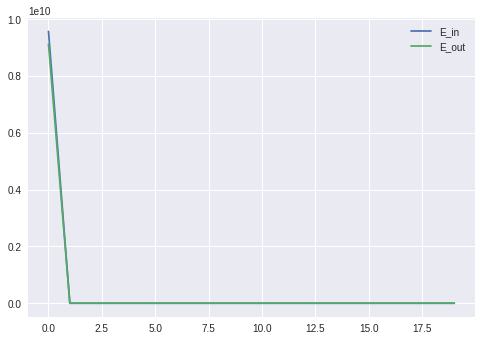

In [130]:
X = train_set.drop(target, axis=1).values
Y = train_set[[target]].values

test_X = test_set.drop(target, axis=1).values
test_Y = test_set[[target]].values

w = np.random.ranf((mu.shape[0],1))
precision_rate = np.random.ranf((mu.shape[0], 1)) /10

num_epochs = 20
learning_rate = 0.00006
E_in = []
E_out = []

for i in range(num_epochs):
  w = regress_w(X, Y, precision_rate, mu)
  precision_rate = descend_lambda(X, Y, precision_rate, learning_rate, mu, w)
  in_sample_mse = refined_loss(X, Y, precision_rate, mu, w)
  mse = refined_loss(test_X, test_Y, precision_rate, mu, w)
  E_in.append(float(in_sample_mse))
  E_out.append(float(mse))
  print('In Sample is {} and Out of sample is {}'.format(in_sample_mse, mse))
  pass
print('Final MSE was {}'.format(mse))

import matplotlib.pyplot as plt

plt.subplot(111)
plt.plot(np.arange(0,i+1,1), E_in, label='E_in')
plt.plot(np.arange(0,i+1,1), E_out, label='E_out')
plt.legend(loc='best')

plt.show()

## 4: Review